In [1]:
import pandas as pd

df = pd.read_csv("stock_price_history.csv")
df.head()
df.info()
df.head()

print (len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135786 entries, 0 to 135785
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                135786 non-null  int64  
 1   stock_id          135786 non-null  int64  
 2   price             135786 non-null  float64
 3   trade_time_stamp  135786 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 4.1+ MB
135786


In [2]:
# Data Cleanup

import pandas as pd

# Load CSV
df = pd.read_csv("stock_price_history.csv")

# Clean & preprocess
df['trade_time_stamp'] = pd.to_datetime(df['trade_time_stamp'], errors='coerce')

# Drop rows with invalid timestamps or missing prices
df.dropna(subset=['trade_time_stamp', 'price'], inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Filter out invalid price entries (<= 0)
df = df[df['price'] > 0]

# Optional: remove rows with absurd jumps (optional for smoothing)
df.sort_values(by=['stock_id', 'trade_time_stamp'], inplace=True)
df['pct_change'] = df.groupby('stock_id')['price'].pct_change()
df = df[df['pct_change'].abs() < 0.5]  # Remove sudden 50%+ spikes
df.drop(columns='pct_change', inplace=True)

# Final sort & reset index
df.reset_index(drop=True, inplace=True)

# Show result
df.head()

print(f"✅ Rows remaining after cleanup: {len(df)}")


✅ Rows remaining after cleanup: 135767


In [3]:
import numpy as np
import pandas as pd

# Hyperparameters
WINDOW_SIZE = 60       # Last 10 minutes
LOOKAHEAD = 6          # Predict 1 minute ahead
THRESHOLD = 0.001      # 0.1% price movement

# Containers
X = []
y = []
meta = []

# Labeling function (binary only)
def get_label(curr_price, future_price, threshold):
    change = (future_price - curr_price) / curr_price
    if change > threshold:
        return 1  # UP
    elif change < -threshold:
        return 0  # DOWN
    else:
        return None  # Skip NEUTRAL

# Apply sliding window per stock
for stock_id, group in df.groupby('stock_id'):
    prices = group['price'].values
    timestamps = group['trade_time_stamp'].values

    for i in range(WINDOW_SIZE, len(prices) - LOOKAHEAD):
        window = prices[i - WINDOW_SIZE:i]
        current_price = prices[i - 1]
        future_price = prices[i + LOOKAHEAD - 1]

        label = get_label(current_price, future_price, THRESHOLD)
        if label is None:
            continue  # Skip neutral cases

        X.append(window)
        y.append(label)
        meta.append({
            'stock_id': stock_id,
            'predict_time': timestamps[i + LOOKAHEAD - 1]
        })

# Convert to arrays
X = np.array(X)
y = np.array(y)
meta_df = pd.DataFrame(meta)

# Print class distribution
classes, counts = np.unique(y, return_counts=True)
class_map = {0: "DOWN", 1: "UP"}
print("✅ Binary Class distribution (NEUTRAL dropped):")
for c, cnt in zip(classes, counts):
    print(f"{class_map[c]}: {cnt} samples")

print(f"✅ Feature shape: X = {X.shape}, y = {y.shape}")


✅ Binary Class distribution (NEUTRAL dropped):
DOWN: 26725 samples
UP: 24609 samples
✅ Feature shape: X = (51334, 60), y = (51334,)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:58:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Binary Classification Report:
              precision    recall  f1-score   support

        DOWN       0.60      0.80      0.69      5345
          UP       0.66      0.42      0.51      4922

    accuracy                           0.62     10267
   macro avg       0.63      0.61      0.60     10267
weighted avg       0.63      0.62      0.60     10267



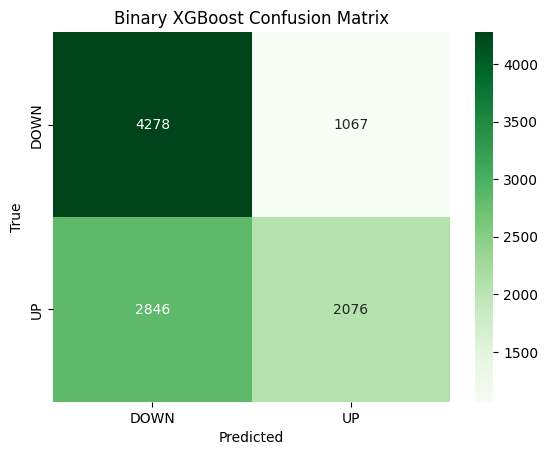

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten for XGBoost
X_flat = X.reshape(X.shape[0], X.shape[1])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Define model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("✅ Binary Classification Report:")
print(classification_report(y_test, y_pred, target_names=["DOWN", "UP"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["DOWN", "UP"], yticklabels=["DOWN", "UP"])
plt.title("Binary XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [39]:
model.save_model("price_model_xgb_binary.json")
